# Eboss H5 Creation

This notebook is used to create the h5py files for the eboss flux datasets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from astropy.io import fits
from glob import glob

from Modeling import CrossValidationModeler, EbossWaveSpectraDataset

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, Conv2D, Conv1D, InputLayer, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

C:\Users\stone\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Seperate Needed values from the dataset.

In [97]:
# Extract needed info.
eboss_ids = pd.read_csv('../../Data/Astronomy.csv')[['ID', 'Hits']]

# Place fitler here.
#eboss_ids = eboss_ids[eboss_ids.ID.str.contains('oneline')]

# Collectors for files
not_found_files_general = []
found_files_general = []

# Needed.
dr_list = ['dr14', 'dr8', 'dr9']
file_list = set(glob('C:/Users/stone/Desktop/Summer2018/AstroProj/Data/RawEboss/*/*e.fits'))
base_directory = r'C:/Users/stone/Desktop/Summer2018/AstroProj/Data/RawEboss\{plate_id}\HIT_SPEC_{dr_version}_{plate_id}_{mjd}_{fiber_id}_fiber_{type}.fits'

# For each id in the initial dataset parse it and read in the values.
for _, e_id, hit in eboss_ids.itertuples():
    plate_id, mjd, fiber_id, file_type = e_id.split('_')
    
    for dr_ver in dr_list:
        file_to_read = base_directory.format(plate_id=plate_id, mjd=mjd, fiber_id=fiber_id, type=file_type, dr_version=dr_ver)
        if file_to_read in file_list:
            fits.open(file_to_read)
            found_files_general.append((e_id, file_to_read, dr_ver, file_type, hit))
            break
    else:
        not_found_files_general.append(e_id)
        
eboss_locations = pd.DataFrame(found_files_general, columns=['id', 'location', 'dr_version', 'file_type', 'hit'])
eboss_locations.to_csv('eboss_locations_oneline.csv')
len(not_found_files_general), len(found_files_general)

(0, 150)

Generate the h5py dataset.

In [92]:
file.close()

In [91]:
del file['flux_values']
del file['flux_labels']
del file['flux_ids']
del file['res_flux_values']
del file['ivar_flux_values']

In [5]:
ebwsd = EbossWaveSpectraDataset('CSVs/eboss_locations_multiline.csv')
num_of_spectra = len(ebwsd)

#del file['flux_values']
#del file['flux_labels']
#del file['flux_ids']
#del file['res_flux_values']
#del file['ivar_flux_values']


#file.close()

#H5 File setup
file = h5py.File('../../Data/eboss_flux_multiline+.hdf5', mode='w')

# del file['flux_values']
# del file['flux_labels']
# del file['flux_ids']
# del file['res_flux_values']
# del file['ivar_flux_values']

file.create_dataset('flux_values', shape=(num_of_spectra, 4639))
file.create_dataset('res_flux_values', shape=(num_of_spectra, 4639))
file.create_dataset('ivar_flux_values', shape=(num_of_spectra, 4639))
file.create_dataset('ivar_rescaled_flux_values', shape=(num_of_spectra, 4639))
file.create_dataset('flux_labels', shape=(num_of_spectra, 1))
file.create_dataset('flux_ids', shape=(num_of_spectra, 1), dtype='S30')

# Set the values of the dataset.
label_mapper = lambda x: 0 if x == 'bad' else 1
ebwsd.spectra_infos.id = ebwsd.spectra_infos.id.astype('S')
for ix in range(len(ebwsd)):
    row = ebwsd[ix]
    file['flux_values'][ix] = row[0]
    file['flux_labels'][ix] = label_mapper(row[1].hit)
    file['flux_ids'][ix] = row[1].id
    
    file['ivar_flux_values'][ix] = ebwsd.get_ext_data(ix, 4)[0]
    file['ivar_rescaled_flux_values'][ix] = ebwsd.get_ext_data(ix, 5)[0]
    file['res_flux_values'][ix] = ebwsd.get_ext_data(ix, 7)[0]
    
    
file.close()

In [6]:
len(ebwsd)

131

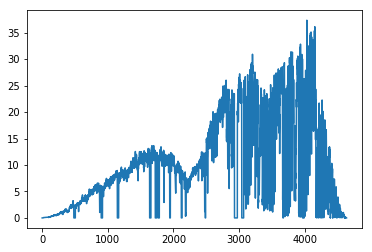

In [13]:
ixx = 1
file = h5py.File('../../Data/eboss_flux_multiline+.hdf5', mode='r')
plt.plot(range(len(file['ivar_rescaled_flux_values'][ixx])), file['ivar_rescaled_flux_values'][ixx])
file.close()

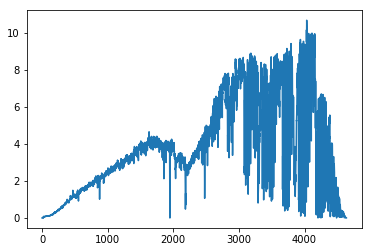

In [83]:
file = h5py.File('../../Data/eboss_flux_full+.hdf5', mode='r')
plt.plot(range(len(file['ivar_flux_values'][0])), file['ivar_flux_values'][0])
file.close()

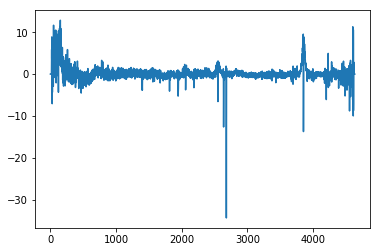

In [94]:
file = h5py.File('../../Data/eboss_flux_full+.hdf5', mode='r')
plt.plot(range(len(file['res_flux_values'][0])), file['res_flux_values'][0])
file.close()